# Neural Network Notebook

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

## Requirements / General Notes:
#### - Try Different Feature Transformations (PCA, ... etc.)
#### - Try Different Model Architecutres (Going to try 3 different model architectures)
#### - Try Different Regulariztions (6 Different values for each model)
#### - Different sybmol ID represent different securities
#### - Time series data, so Date ID is important

In [ ]:
# configs
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 100)

## Data Imports (Data Already Scaled & Normalized Thanks MJ :) )

In [2]:
train_val_df = pd.read_csv('/kaggle/input/test-df-sn-js2024/df_test_scaled_normalized.csv')
test_df = pd.read_csv('/kaggle/input/tr-val-sn-js2024/df_miss_outliers_replaced_scaled_normalized.csv')

## Data preparation for training and validation

In [5]:

#Splitting features and targets
train_val_features = train_val_df.drop(columns=['responder_6']).values
train_val_target = train_val_df['responder_6'].values

#Converting them into torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  

Total dataset size: 471486
Training dataset size: 377188
Validation dataset size: 94298
Training batch - Inputs: torch.Size([32, 91]) Targets: torch.Size([32, 1])
Validation batch - Inputs: torch.Size([32, 91]) Targets: torch.Size([32, 1])


### Custom Dataset Class
#### Was having issues with using X and y as pure torchTesnors, so I created a custom dataset class

In [9]:
class TimeSeriesDataset(Dataset): #Took a minute, but apparently it must inherit from the PyTorch "Abstract Dataset Class"
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

dataset = TimeSeriesDataset(X_tensor, y_tensor)

train_ratio = 0.8  # 80% for training, 20% for validation
train_size = int(len(dataset) * train_ratio)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) #Splits the data dandomly 

# Using Pytorch DataLoaders - It is a must for using PyToech
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Printing dataset sizes 
print("Total dataset size: ", len(dataset))
print("Training dataset size: ", len(train_dataset))
print("Validation dataset size: len(val_dataset)", len(val_dataset))

for batch in train_loader:
    inputs, targets = batch
    print("Training batch - Inputs:", inputs.shape, "Targets:", targets.shape)
    break

for batch in val_loader:
    inputs, targets = batch
    print("Validation batch - Inputs:", inputs.shape, "Targets:", targets.shape)
    break

Total dataset size:  471486
Training dataset size:  377188
Validation dataset size: len(val_dataset) 94298
Training batch - Inputs: torch.Size([32, 91]) Targets: torch.Size([32, 1])
Validation batch - Inputs: torch.Size([32, 91]) Targets: torch.Size([32, 1])


## Multi-Layer Perceptron Architecture

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units=[128, 64], output_dim=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units[0])
        self.fc2 = nn.Linear(hidden_units[0], hidden_units[1])
        self.fc3 = nn.Linear(hidden_units[1], output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_dim = X.shape[1]  # Number of features
model = MLP(input_dim)

## Model Training

In [12]:
%%time

def train_model(num_epochs, data_loader, lambda_):

    #Opting for a the adam optimizer, may switch it up, depending on time constraints
    #Also, going with the Mean-Squard error for measuring loss
    
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=lambda_)
    criterion = nn.MSELoss() 
    
    losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in data_loader:
            inputs, targets = batch

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(data_loader):.4f}")
        losses.append(running_loss/len(data_loader))


num_epochs = 5
lambda_ = 1e-4
train_model(num_epochs, train_loader, lambda_)

Epoch [1/5], Loss: 0.2233
Epoch [2/5], Loss: 0.1996
Epoch [5/5], Loss: 0.1759
CPU times: user 8min 24s, sys: 1.4 s, total: 8min 25s
Wall time: 4min 13s


## Model Evaluation

In [14]:

def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    targets = []
    total_loss = 0.0
    
    with torch.no_grad():  # Disabling gradent calculation
        for inputs, labels in dataloader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Store predictions and targets
            predictions.append(outputs.cpu().numpy())
            targets.append(labels.cpu().numpy())
    
    
    # Combine all predictions and targets
    predictions = np.vstack(predictions)
    targets = np.vstack(targets)
    
    # Metrics for calculated on the validation set
    mse = mean_squared_error(targets, predictions)  # Mean-Squared Error
    mae = mean_absolute_error(targets, predictions) # Mean-Aboslute Error 
    r2 = r2_score(targets, predictions)             # R2 Score
    
    # Average loss
    avg_loss = total_loss / len(dataloader)
    
    metrics = {
        "Loss (MSE)": avg_loss,
        "Mean Squared Error": mse,
        "Mean Absolute Error": mae,
        "R2 Score": r2,
    }
    
    return metrics, predictions, targets


#criterion = torch.nn.MSELoss()

metrics, predictions, targets = evaluate_model(model, val_loader, criterion)

print("Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Evaluation Metrics:
Loss (MSE): 0.2279
Mean Squared Error: 0.2279
Mean Absolute Error: 0.3209
R2 Score: 0.7146


## Training Loss and Epochs Graph

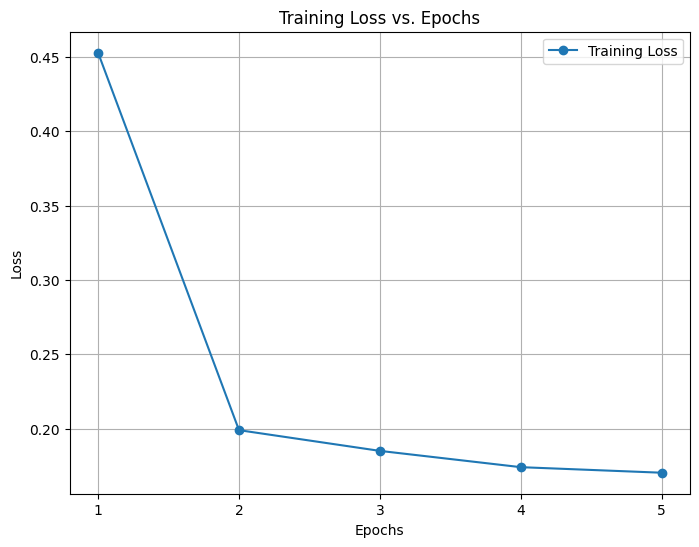

In [15]:

def plot_training_loss(losses, title="Training Loss vs. Epochs"):
    
    epochs = range(1, len(losses) + 1)  # Epoch numbers (1-based index)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, losses, marker='o', label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(epochs)  # Set x-axis ticks to correspond to each epoch
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_training_loss(losses)

#### I will run all of the tests tomorrow. This is set up nicely. Should take like 10 minutes, or more depending on how daunting the training is.